<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Scratch_CNN_benign_vs_malign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **benign vs malign samples**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 

from tensorflow.keras import backend as K # Useful to free GPU and memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras import layers
from keras import optimizers 
from keras import models
from keras import regularizers

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project/numpy data"
train_img_path = os.path.join(base_path, 'train_tensor.npy')
train_label_path = os.path.join(base_path, 'train_labels.npy')
test_img_path = os.path.join(base_path, 'public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'public_test_labels.npy')

print("Done")

Done


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)


Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


## Data preprocessing

Currently, our data sits on a drive as numpy files (**.npy**), so the steps for getting it into our network are roughly:



In [ ]:
#1: Mass, benign
#2: Mass, malignant
#3: Calcification, benign
#4: Calcification, malignant

#count #of masses and #of calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)

print("Benign Masses samples: \t", counts[0])
print("Malign Masses samples: \t", counts[1])
print("Benign Calc samples: \t", counts[2])
print("Malign Calc samples: \t", counts[3])

Benign Masses samples: 	 620
Malign Masses samples: 	 598
Benign Calc samples: 	 948
Malign Calc samples: 	 510


In [ ]:
# Unify benign and malign cases 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # malign
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

# Visualization Data Histogram
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])

train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [ ]:
# split dataset into training and validation set 70-30
train_images_split = train_images[:int(0.7*len(train_images))]
valid_images_split = train_images[int(0.7*len(train_images)):]
train_labels_split = train_labels[:int(0.7*len(train_labels))]
valid_labels_split = train_labels[int(0.7*len(train_labels)):]

print(train_images_split.shape)
print(valid_images_split.shape)                                       

(1873, 150, 150, 1)
(803, 150, 150, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./65535
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break



(20, 150, 150, 1)
(20,)


## Defining CNN 


In [ ]:
from keras import layers
from keras import optimizers 
from keras import models
from keras import regularizers

def build_model(loss_function, eval_metric):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  #model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001
              metrics=["acc"]) 
  
  return model 

## CNN Compilation:



In [ ]:
from keras import optimizers 

model = build_model("binary_crossentropy", "acc")

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)


Epoch 1/100
93/93 [==============================] - 3s 22ms/step - loss: 0.6921 - acc: 0.5683 - val_loss: 0.6833 - val_acc: 0.5850
Epoch 2/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6827 - acc: 0.5826 - val_loss: 0.6690 - val_acc: 0.6150
Epoch 3/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6618 - acc: 0.6169 - val_loss: 0.6448 - val_acc: 0.6300
Epoch 4/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6460 - acc: 0.6306 - val_loss: 0.6371 - val_acc: 0.6463
Epoch 5/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6448 - acc: 0.5996 - val_loss: 0.6405 - val_acc: 0.6338
Epoch 6/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6318 - acc: 0.6406 - val_loss: 0.6301 - val_acc: 0.6575
Epoch 7/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6284 - acc: 0.6298 - val_loss: 0.6249 - val_acc: 0.6125
Epoch 8/100
93/93 [==============================] - 2s 20ms/step - loss: 0.

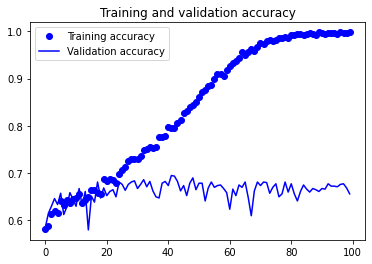

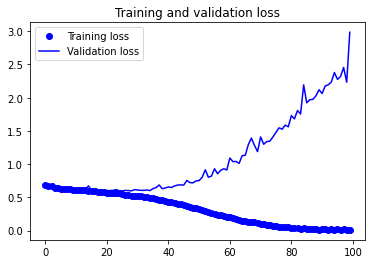

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 2.7742 - acc: 0.6469
0.6468750238418579


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.68      0.84      0.75       219
         1.0       0.47      0.26      0.34       117

    accuracy                           0.64       336
   macro avg       0.58      0.55      0.55       336
weighted avg       0.61      0.64      0.61       336



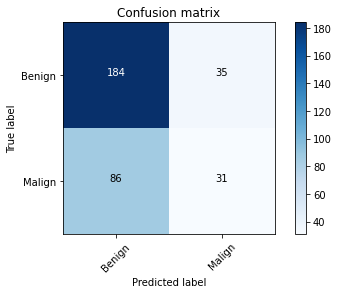

In [ ]:
#print confusion matrix
plot_confusion_matrix(classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

In [ ]:
#ROC-AUC 

## Dealing with imbalanced dataset: 
**1.Weighted Class Approah**

In [ ]:
from sklearn.utils import class_weight

#compute class_weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels_split),
                                                 train_labels_split)

class_weights = {0: class_weights[0],
                 1: class_weights[1]}

print(class_weights)

{0: 0.8521383075523203, 1: 1.2099483204134367}


In [ ]:
model = build_model("binary_crossentropy", "acc")

#model.summary()

history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=class_weights)


Epoch 1/100
93/93 [==============================] - 3s 22ms/step - loss: 0.6965 - acc: 0.5101 - val_loss: 0.6894 - val_acc: 0.5713
Epoch 2/100
68/93 [====================>.........] - ETA: 0s - loss: 0.6893 - acc: 0.5177

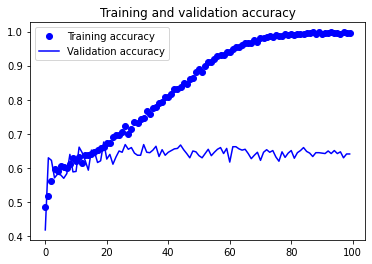

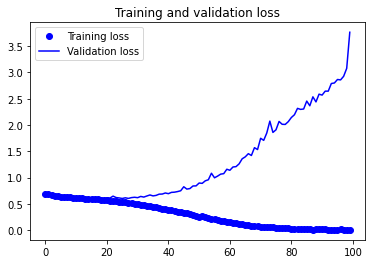

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 3.3172 - acc: 0.6219
0.621874988079071


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74       219
         1.0       0.41      0.22      0.29       117

    accuracy                           0.62       336
   macro avg       0.54      0.53      0.51       336
weighted avg       0.58      0.62      0.58       336



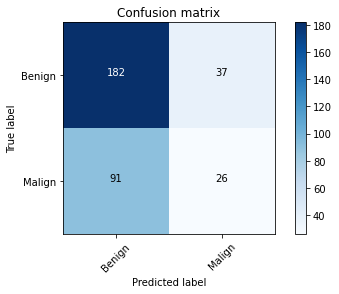

In [ ]:
plot_confusion_matrix(classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  